<font size="3">

# Measuring Respiration and Pulse Rate Lab

## Introduction

**Seismocardiography (SCG)** is a non-invasive method that captures the mechanical activity of the heart by measuring chest wall vibrations using accelerometers. These vibrations occur during different phases of the cardiac cycle, such as the contraction of the ventricles and the movement of heart valves. The use of accelerometers for continuous heart monitoring is gaining popularity, especially for wearable healthcare devices.

Respiration rate, on the other hand, can be determined by detecting changes in the chest's orientation relative to Earth's gravitational field during breathing. As a person breathes, the expansion and contraction of the chest cause subtle changes in its angle and position, which can be captured by accelerometers sensitive to gravitational acceleration.

In this nootebook, you will work with real-world data collected during experiments with the Phyphox app to extract two crucial physiological metrics:
- **Pulse Rate (PR)**: Measured using seismocardiography by capturing chest vibrations caused by the heart's mechanical activity.
- **Respiration Rate (RR)**: Determined by detecting changes in the chest's angle relative to Earth's gravitational field during breathing movements.

We will show how to preprocess the accelerometer data by resampling, perform spectral analysis to identify dominant frequency components, design filters based on spectral findings, and perform peak detection to calculate PR and RR. Additionally, we will explore the effects of motion artifacts by running the analysis on clean and artifact-induced data.

In this notebook, we:

- Load and resample accelerometry data
- Perform spectral analysis to identify dominant frequency components
- Design Butterworth bandpass filters for respiration and pulse signals
- Apply filtering (both causal and zero-phase)
- Detect peaks to estimate PR and RR (including using the envelope of the pulse signal)
- Calculate instantaneous and averaged PR and RR over a 1-minute period
- (Optionally) Estimate rates from the PSD and explore interactions between PR and RR

 **Note**: 
 
- Throughout the notebook, you may need to adjust parameters (cutoff frequencies, filter order, peak detection thresholds, etc.) based on your data.

- The data file is assumed to be in the folder: ...\Learn Remote Patient Monitoring\Datasets\Accelerometry

- Feel free to download and use Phyphox app on your smartphone to gather and export accelerometry signal on your own chest. You can ask an assistant to provide you with a referecne by manually counting your breathing rate and pulse rate.

</font>



<font size="3">

### Step 0: Initialization and Imports

First, we import the necessary libraries and set up our environment.

</font>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, periodogram, find_peaks, hilbert
from scipy.interpolate import interp1d

# Set matplotlib to display plots
%matplotlib widget

<font size="3">

### Step 1: Load and Inspect the Data

We will load the accelerometry  data, which contains acceleration signals along the X, Y, and Z axes. These signals capture the movement of the chest wall caused by pulsebeats and respiration.

Here we assume the accelerometry data is stored in a CSV file with the following columns:
- `Time (s)`
- `Acceleration x (m/s^2)`
- `Acceleration y (m/s^2)`
- `Acceleration z (m/s^2)`

</font>

In [2]:
# Set the folder path and file name (adjust as per your local directory)
folder_path = r'C:\Users\20181588\Desktop\Learn Remote Patient Monitoring\Datasets\Accelerometry'   # <-- Modify this path
data_file = 'Accelerometry_data.csv'                  # <-- Modify the file name

# Full path to the CSV file
data_path = os.path.join(folder_path, data_file)

# Load the accelerometry data; assuming CSV with header
data = pd.read_csv(data_path)

# Display column names and preview first few rows
print("Columns in the dataset:")
print(data.columns.tolist())
print("\nFirst few rows of the data:")
print(data.head())

Columns in the dataset:
['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']

First few rows of the data:
   Time (s)  Acceleration x (m/s^2)  Acceleration y (m/s^2)  \
0  0.005187                0.158017                3.986346   
1  0.008265                0.158017                3.995923   
2  0.009291                0.167594                4.000711   
3  0.012262                0.181959                4.005499   
4  0.013402                0.191536                4.003105   

   Acceleration z (m/s^2)  Absolute acceleration (m/s^2)  
0                8.839393                       9.697978  
1                8.851364                       9.712827  
2                8.860941                       9.723685  
3                8.875306                       9.739004  
4                8.892065                       9.753479  


<font size="3">

### Step 2: Extract and Resample Time and Acceleration Signals

The accelerometry data may have non-uniform time intervals. For accurate signal processing, we need to ensure that the time intervals are uniform by resampling the data.

**Why Resample the Data?**

- **Uniform Sampling**: Many signal processing techniques assume the data is uniformly sampled. Non-uniform intervals can distort filtering and spectral analysis results
- **Interpolation**: Resampling ensures a consistent sampling frequency by interpolating the data over equally spaced time points

Here we:

- Extract the original time vector and acceleration signals (x, y, and z)
- Create a new, uniform time vector using a desired sampling rate (fs_new)
- Interpolate the acceleration data onto the new time vector

</font>

In [7]:
# Desired new sampling rate (Hz)
fs_new = 125  

# Extract original time and acceleration data (ensure they are one‑dimensional arrays)
original_time = data['Time (s)'].values.flatten()
acc_x = data['Acceleration x (m/s^2)'].values.flatten()
acc_y = data['Acceleration y (m/s^2)'].values.flatten()
acc_z = data['Acceleration z (m/s^2)'].values.flatten()

# Create a new uniform time vector from the start to end of the original time vector.
time = np.arange(original_time[0], original_time[-1], 1/fs_new)
time = time.reshape(-1)  # ensure 1D

# Interpolate the acceleration signals onto the new time vector using linear interpolation
acc_x = interp1d(original_time, acc_x, kind='linear', fill_value="extrapolate")(time)
acc_y = interp1d(original_time, acc_y, kind='linear', fill_value="extrapolate")(time)
acc_z = interp1d(original_time, acc_z, kind='linear', fill_value="extrapolate")(time)

# Confirm the new sampling rate
fs_check = 1 / np.mean(np.diff(time))
print(f"Sampling Rate: {fs_check:.2f} Hz")


Sampling Rate: 125.00 Hz


<font size="3">

### Step 3: Understanding the Acceleration Axes and Visualizing the Raw Acceleration Data

The accelerometry sensor records acceleration along three orthogonal axes:
- X-Axis (Lateral Movement): Captures side-to-side movements
- Y-Axis (Superior-Inferior Movement): Primarily captures chest movement during respiration
- Z-Axis (Anterior-Posterior Movement): Captures the mechanical vibrations of the heart

**Why Use the Y and Z Axes?**
- Respiration Rate (RR): The Y-axis is sensitive to the chest's expansion and contraction during breathing
- Pulse Rate (PR): The Z-axis captures subtle vibrations associated with the pulsebeat

Understanding which axis corresponds to each physiological signal is essential for accurate PR and RR estimation.

below we plot the data along the X, Y, and Z axes to understand the signal characteristics.

</font>

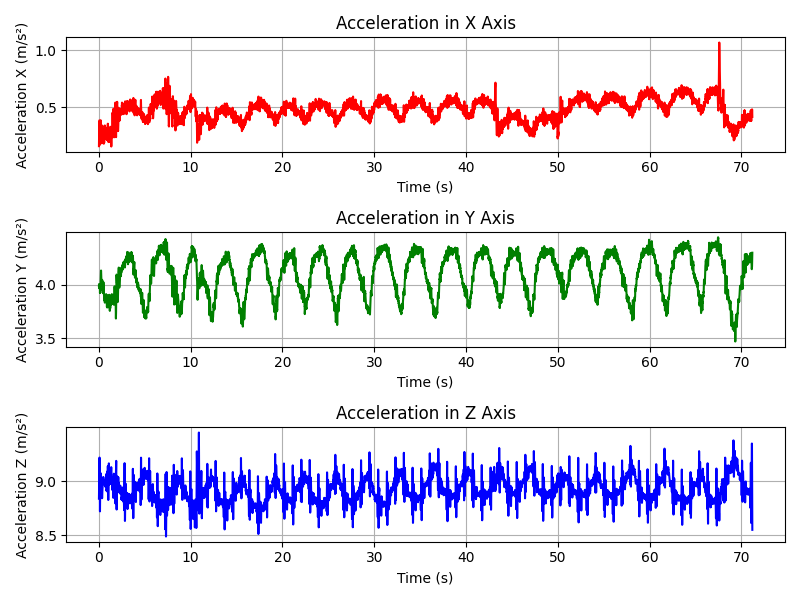

In [10]:
plt.figure(figsize=(8, 6))

plt.subplot(3, 1, 1)
plt.plot(time, acc_x, 'r')
plt.title('Acceleration in X Axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration X (m/s²)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, acc_y, 'g')
plt.title('Acceleration in Y Axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration Y (m/s²)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, acc_z, 'b')
plt.title('Acceleration in Z Axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration Z (m/s²)')
plt.grid(True)

plt.tight_layout()
plt.show()


<font size="3">

### Step 4: Spectral Analysis

Spectral analysis transforms a time-domain signal into its frequency-domain representation, allowing us to identify dominant frequency components related to physiological processes, such as pulse beats and respiration.

**Why Perform Spectral Analysis?**
- **Identify Dominant Frequencies**: Pulse rate and respiration rate correspond to specific frequency ranges
- **Filter Design**: Helps in determining the appropriate cutoff frequencies for filtering

**Theoretical Background:**
- **Fourier Transform (FFT)**: Converts a time-domain signal into the frequency domain
- **Power Spectral Density (PSD)**: Represents how the power of a signal is distributed over different frequencies
- **Periodogram**: Estimates the PSD using the squared magnitude of the FFT

**Note**:
- Y-axis is assumed to reflect respiration-related movements  
- Z-axis is assumed to capture pulse-related mechanical vibrations

</font>

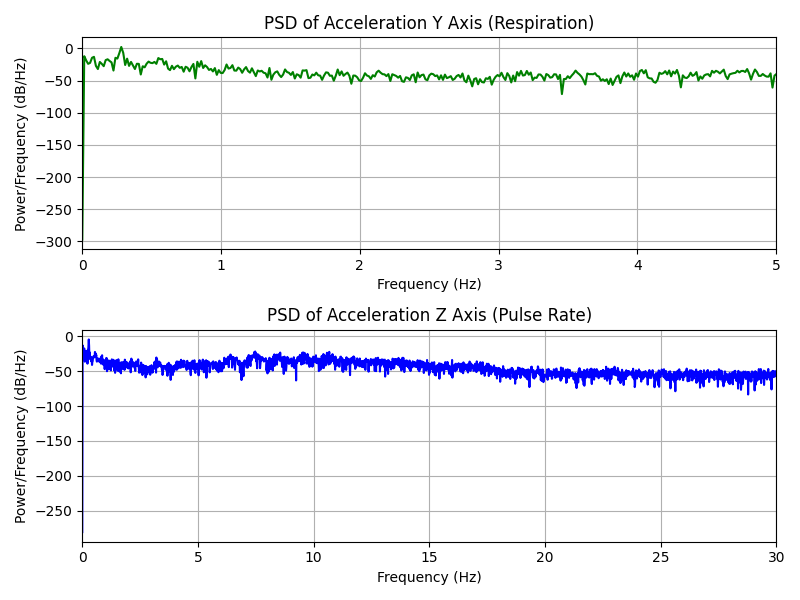

In [11]:
# Compute PSD for acc_y (respiration axis)
F_y, Pxx_y = periodogram(acc_y, fs=fs_check)
# Compute PSD for acc_z (pulse rate axis)
F_z, Pxx_z = periodogram(acc_z, fs=fs_check)

# Plot the PSD for each axis
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(F_y, 10*np.log10(Pxx_y), 'g')
plt.xlim([0, 5])  # Focus on 0-5 Hz for respiration
plt.title('PSD of Acceleration Y Axis (Respiration)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(F_z, 10*np.log10(Pxx_z), 'b')
plt.xlim([0, 30])  # Focus on 0-30 Hz for pulse rate
plt.title('PSD of Acceleration Z Axis (Pulse Rate)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.tight_layout()
plt.show()

<font size="3">

**Interpreting the Spectral Analysis:**
- **RR**: Typically corresponds to frequencies between **0.1 Hz and 0.5 Hz** (6 bpm to 30 bpm)
- **PR**: In SCG signals, the mechanical vibrations of the heart produce frequency components typically ranging from **5 Hz to 20 Hz** due to mechanical events within each pulsebeat

</font>


<font size="3">

### Step 5: Filter Design and Parameter Selection

Based on the spectral analysis, design bandpass filters to isolate the pulse rate and respiration rate signals.

**Filter Parameters for Respiration Rate**:
- **Low cutoff frequency (f_rl)**: Set slightly below the lowest significant frequency identified for respiration
- **High cutoff frequency (f_rh)**: Set slightly above the highest significant frequency identified for respiration

**Filter Parameters for Pulse Rate**:
- **Low cutoff frequency (f_hl)**: Set slightly below the lowest significant frequency identified for pulse rate
- **High cutoff frequency (f_hh)**: Set slightly above the highest significant frequency identified for pulse rate

Based on the PSD, we choose cutoff frequencies. For example:

- **Respiration Rate (RR):** 0.1 to 0.5 Hz  
- **Pulse Rate (PR):** 5 to 20 Hz  

We normalize the cutoff frequencies by (fs/2) and design 3rd‑order Butterworth bandpass filters.

</font>

In [12]:
# Respiration Rate Filter Parameters
f_rl = 0.1  # low cutoff for respiration (Hz)
f_rh = 0.5  # high cutoff for respiration (Hz)

# Pulse Rate Filter Parameters
f_pl = 5    # low cutoff for pulse rate (Hz)
f_ph = 20   # high cutoff for pulse rate (Hz)

# Normalize cutoff frequencies (Nyquist frequency = fs_check/2)
Wn_rr = [f_rl/(fs_check/2), f_rh/(fs_check/2)]
Wn_pr = [f_pl/(fs_check/2), f_ph/(fs_check/2)]

# Set filter orders
order_rr = 3
order_pr = 3

# Design Butterworth bandpass filters
b_rr, a_rr = butter(order_rr, Wn_rr, btype='bandpass')
b_pr, a_pr = butter(order_pr, Wn_pr, btype='bandpass')

<font size="3">

### Step 6: Apply Filters to the Signals

We filter:
- The Y‑axis signal (acc_y) for respiration rate  
- The Z‑axis signal (acc_z) for pulse rate  

For demonstational purposes we will show both forward‑only filtering (lfilter) and zero‑phase filtering (filtfilt).

</font>

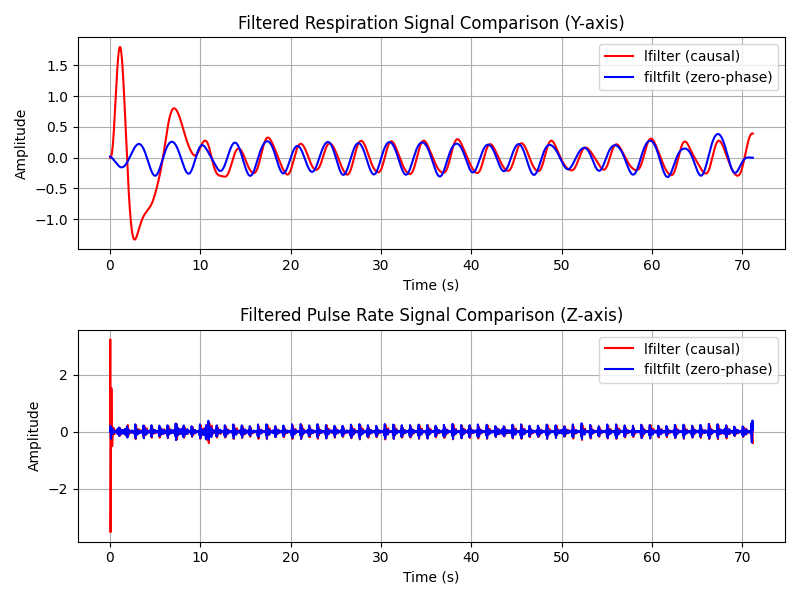

In [14]:
# Apply filters using lfilter (causal, forward only)
filtered_rr_filter = lfilter(b_rr, a_rr, acc_y)
filtered_pr_filter = lfilter(b_pr, a_pr, acc_z)

# Apply filters using filtfilt (zero-phase filtering)
filtered_rr_filtfilt = filtfilt(b_rr, a_rr, acc_y)
filtered_pr_filtfilt = filtfilt(b_pr, a_pr, acc_z)

# Plot comparison for respiration signal
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(time, filtered_rr_filter, 'r', label='lfilter (causal)')
plt.plot(time, filtered_rr_filtfilt, 'b', label='filtfilt (zero-phase)')
plt.title('Filtered Respiration Signal Comparison (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot comparison for pulse rate signal
plt.subplot(2, 1, 2)
plt.plot(time, filtered_pr_filter, 'r', label='lfilter (causal)')
plt.plot(time, filtered_pr_filtfilt, 'b', label='filtfilt (zero-phase)')
plt.title('Filtered Pulse Rate Signal Comparison (Z-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<font size="3">

### Step 7: Visualize the Filtered Signals

We now inspect the zero‑phase filtered signals.

</font>

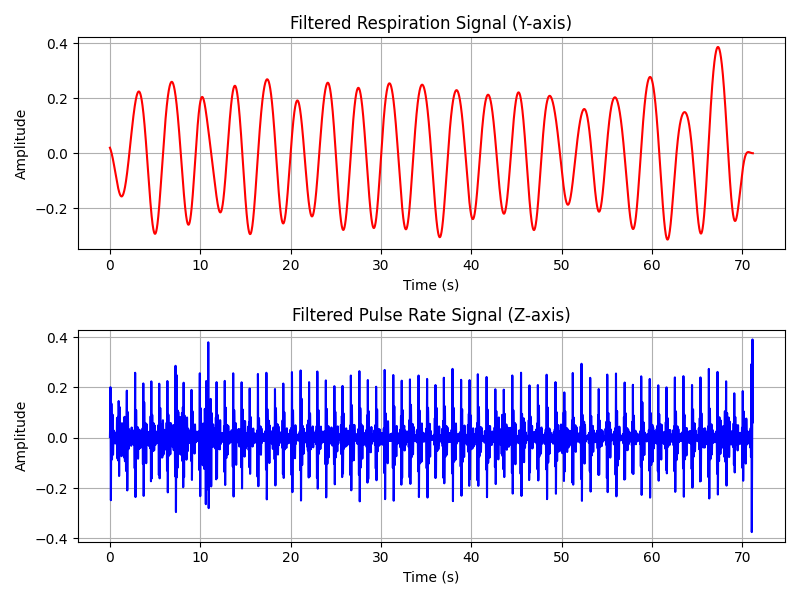

In [16]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(time, filtered_rr_filtfilt, 'r')
plt.title('Filtered Respiration Signal (Y-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, filtered_pr_filtfilt, 'b')
plt.title('Filtered Pulse Rate Signal (Z-axis)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

<font size="3">

### Step 8: Spectral Analysis of Filtered Signals

We compute the PSD of the filtered signals to verify that the filters have isolated the desired frequency ranges.

</font>

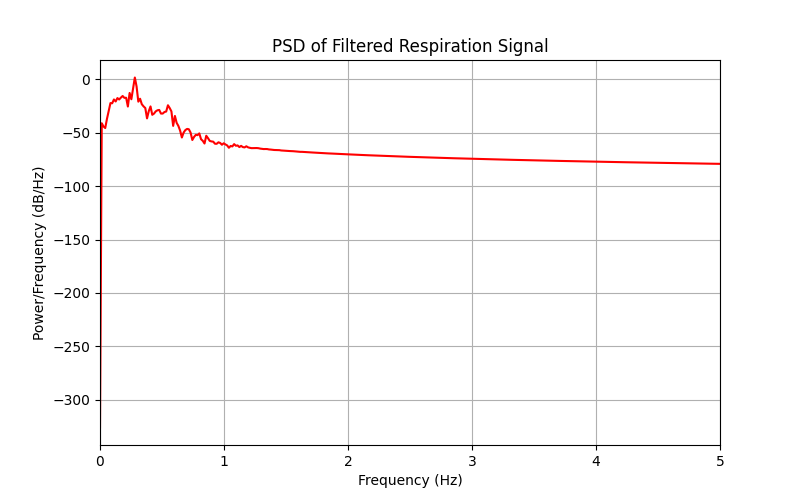

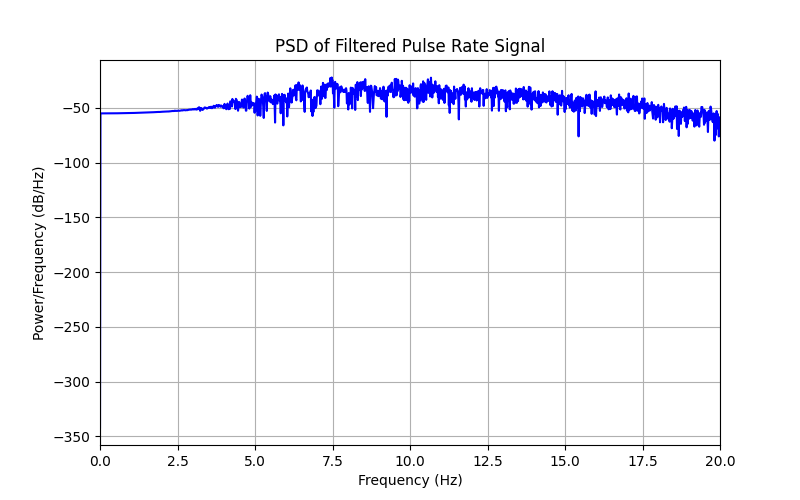

In [18]:
# Compute PSD of the filtered respiration signal
F_rr_filtered, Pxx_rr_filtered = periodogram(filtered_rr_filtfilt, fs=fs_check)
# Compute PSD of the filtered pulse rate signal
F_pr_filtered, Pxx_pr_filtered = periodogram(filtered_pr_filtfilt, fs=fs_check)

# Plot the PSD of the filtered respiration signal
plt.figure(figsize=(8, 5))
plt.plot(F_rr_filtered, 10*np.log10(Pxx_rr_filtered), 'r')
plt.xlim([0, 5])
plt.title('PSD of Filtered Respiration Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

# Plot the PSD of the filtered pulse rate signal
plt.figure(figsize=(8, 5))
plt.plot(F_pr_filtered, 10*np.log10(Pxx_pr_filtered), 'b')
plt.xlim([0, 20])
plt.title('PSD of Filtered Pulse Rate Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()


<font size="3">

###  Step 9: Peak Detection for Respiration and Pulse Rate

Implement peak detection on the filtered signals to estimate respiration rate (RR) and pulse rate (PR).

**Physiological limits:**  
The Physiological limits parameter define the minimum allowed time between consecutive peaks. It should be based on physiological limits:

- **RR:** The maximum expected rate is 30 breaths per minute (bpm), which corresponds to a minimum interval of 2 seconds between breaths
- **PR:** The maximum expected rate is 120 bpm, meaning the minimum interval between beats is 0.5 seconds

We convert these time intervals to sample distances.

</font>

In [19]:
# Convert minimum peak distance (in seconds) to samples
min_peak_dist_rr = int(2 * fs_check)    # For respiration: 2 sec
min_peak_dist_pr = int(0.5 * fs_check)    # For pulse: 0.5 sec

# Detect peaks in filtered respiration signal (using filtfilt result)
resp_indices, _ = find_peaks(filtered_rr_filtfilt, distance=min_peak_dist_rr)
resp_peaks = filtered_rr_filtfilt[resp_indices]
resp_locs = time[resp_indices]

# Detect peaks in filtered pulse rate signal (using filtfilt result)
pulse_indices, _ = find_peaks(filtered_pr_filtfilt, distance=min_peak_dist_pr)
pulse_peaks = filtered_pr_filtfilt[pulse_indices]
pulse_locs = time[pulse_indices]

print(f"Number of Respiration Peaks Detected: {len(resp_peaks)}")
print(f"Number of Pulse Peaks Detected: {len(pulse_peaks)}")

Number of Respiration Peaks Detected: 20
Number of Pulse Peaks Detected: 78


<font size="3">

### Step 10: Visualize Detected Peaks

Plot the detected peaks on top of the filtered signals to visually validate the peak detection algorithm.

</font>

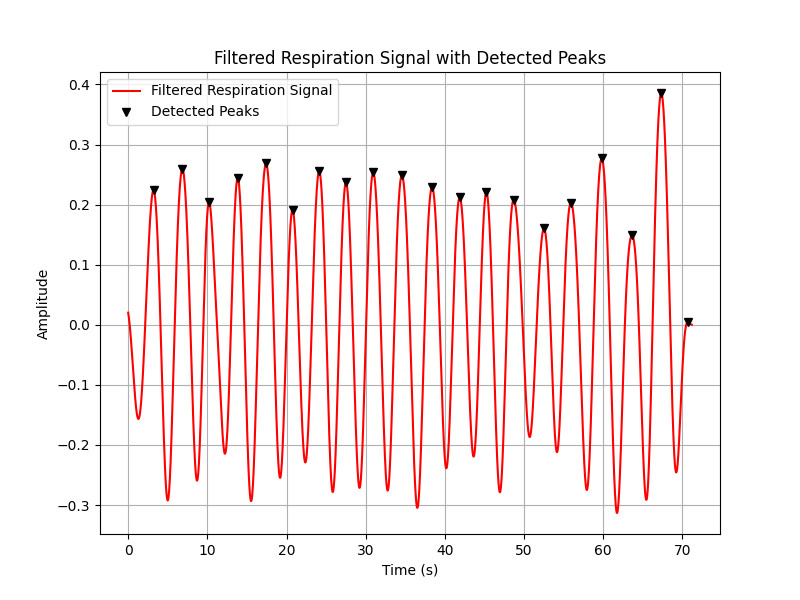

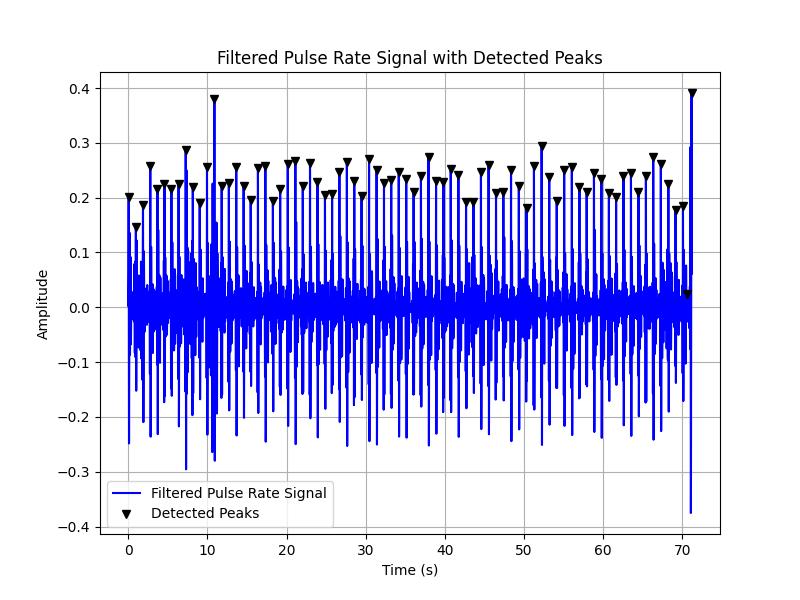

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(time, filtered_rr_filtfilt, 'r', label='Filtered Respiration Signal')
plt.plot(resp_locs, resp_peaks, 'kv', markerfacecolor='k', label='Detected Peaks')
plt.title('Filtered Respiration Signal with Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(time, filtered_pr_filtfilt, 'b', label='Filtered Pulse Rate Signal')
plt.plot(pulse_locs, pulse_peaks, 'kv', markerfacecolor='k', label='Detected Peaks')
plt.title('Filtered Pulse Rate Signal with Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

<font size="3">

### Step 11: Calculate Respiration Rate (RR) and Pulse Rate (PR)

After detecting peaks, we can calculate the RR in breaths per minute and the PR in beats per minute. Compute the intervals between successive peaks, convert to rates, and then average.

</font>

In [21]:
# Respiration rate
resp_intervals = np.diff(resp_locs)           # in seconds
resp_rate = 60 / resp_intervals                # breaths per minute
avg_resp_rate = np.mean(resp_rate)

# Pulse rate
pulse_intervals = np.diff(pulse_locs)           # in seconds
pulse_rate = 60 / pulse_intervals              # beats per minute
avg_pulse_rate = np.mean(pulse_rate)

print(f"Average Respiration Rate: {avg_resp_rate:.2f} breaths per minute")
print(f"Average Pulse Rate: {avg_pulse_rate:.2f} beats per minute")

Average Respiration Rate: 16.94 breaths per minute
Average Pulse Rate: 65.54 beats per minute


<font size="3">

### Step 12: Estimating Pulse Rate from the Envelope of the Filtered Signal

Background:
In seismocardiography (SCG) signals, the mechanical vibrations caused by pulsebeats can produce complex waveforms with multiple peaks within a single cardiac cycle. This can make peak detection on the raw or even filtered SCG signal challenging. To improve the reliability of pulse rate estimation, we can compute the envelope of the filtered pulse rate signal. **The envelope represents the overall amplitude modulation of the signal, highlighting the periodicity corresponding to pulsebeats.**

**Why Use the Envelope?**
- **Simplifies the Signal**: The envelope smooths out high-frequency variations, emphasizing the general shape of the waveform
- **Highlights Periodicity**: The periodic nature of the pulsebeats becomes more apparent in the envelope, making peak detection more reliable
- **Reduces Noise Influence**: The envelope can help mitigate the effects of high-frequency noise and artifacts

**How to Obtain the Envelope:**
- Use the **Hilbert Transform** to compute the analytical signal
- The magnitude (absolute value) of the analytical signal is the envelope of the original signal

To improve detection in SCG signals, we compute the envelope of the filtered pulse rate signal.

</font>

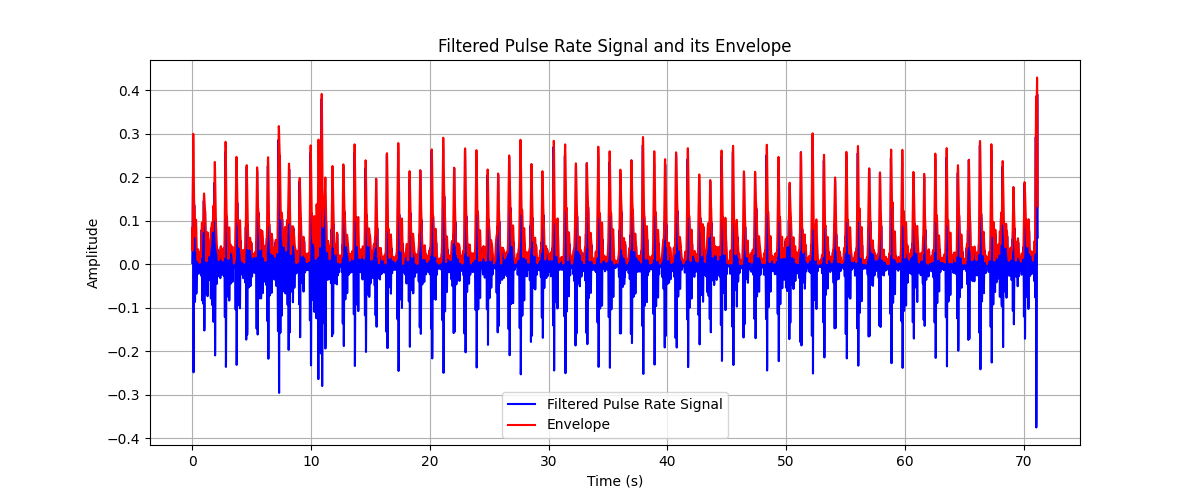

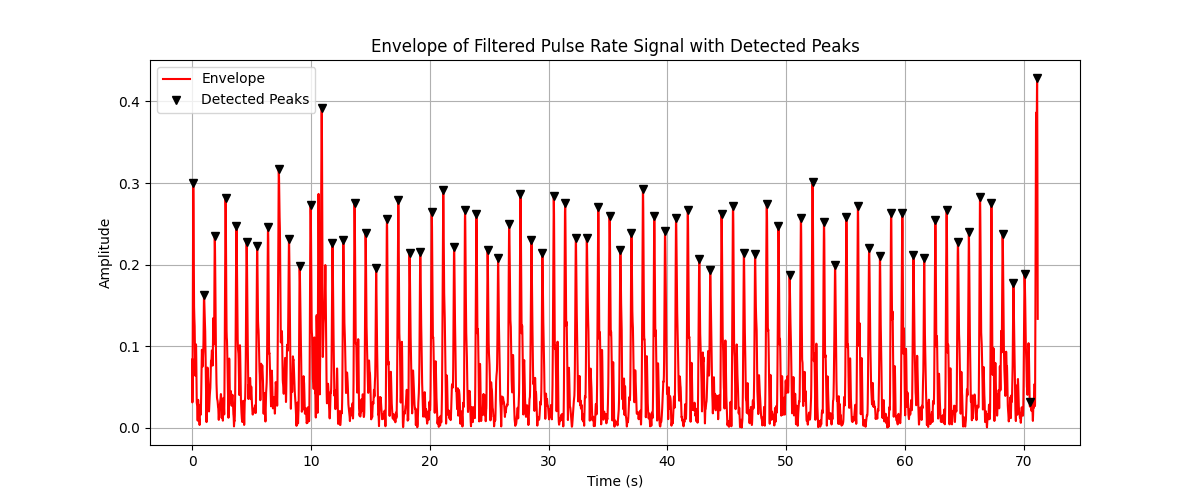

Average Pulse Rate from Envelope Peak Detection: 65.65 beats per minute


In [22]:
# Compute the envelope using the Hilbert transform
envelope_pr = np.abs(hilbert(filtered_pr_filtfilt))

# Plot the filtered pulse rate signal and its envelope
plt.figure(figsize=(12, 5))
plt.plot(time, filtered_pr_filtfilt, 'b', label='Filtered Pulse Rate Signal')
plt.plot(time, envelope_pr, 'r', linewidth=1.5, label='Envelope')
plt.title('Filtered Pulse Rate Signal and its Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Detect peaks on the envelope using the same minimum peak distance
env_indices, _ = find_peaks(envelope_pr, distance=min_peak_dist_pr)
envelope_peaks = envelope_pr[env_indices]
envelope_locs = time[env_indices]

# Plot envelope with detected peaks
plt.figure(figsize=(12, 5))
plt.plot(time, envelope_pr, 'r', label='Envelope')
plt.plot(envelope_locs, envelope_peaks, 'kv', markerfacecolor='k', label='Detected Peaks')
plt.title('Envelope of Filtered Pulse Rate Signal with Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Calculate pulse rate from envelope peaks
pulse_intervals_env = np.diff(envelope_locs)
pulse_rate_env = 60 / pulse_intervals_env
avg_pulse_rate_env = np.mean(pulse_rate_env)
print(f"Average Pulse Rate from Envelope Peak Detection: {avg_pulse_rate_env:.2f} beats per minute")

<font size="3">

**Notes:**
- Comparing the average pulse rate obtained from peak detection on the envelope to the one obtained earlier can provide insights into the effectiveness of this method
- **You are not required to code this step; the code is provided for you to run and observe the results**

</font>



<font size="3">


### Step 13: Pulse Rate and Respiration Rate Change Over Time

Visualize how pulse rate and respiration rate change over time by plotting the rates at each detected peak.

</font>

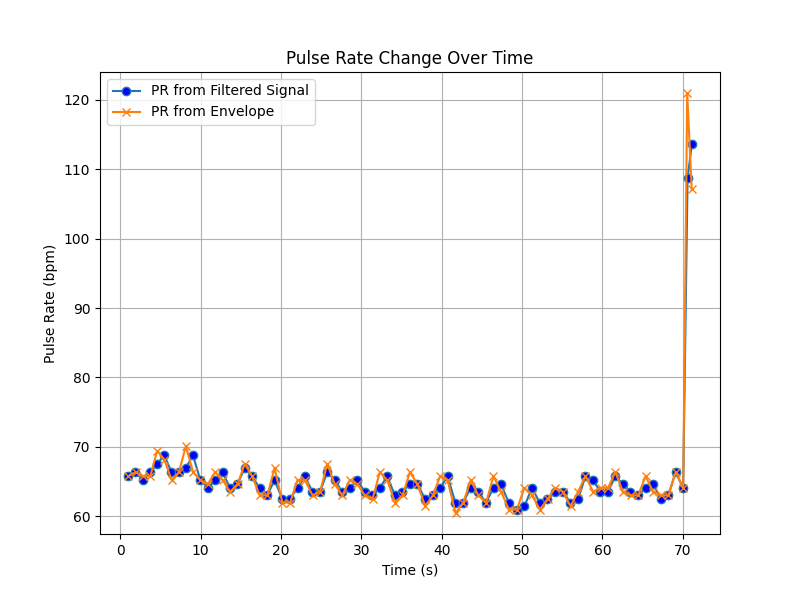

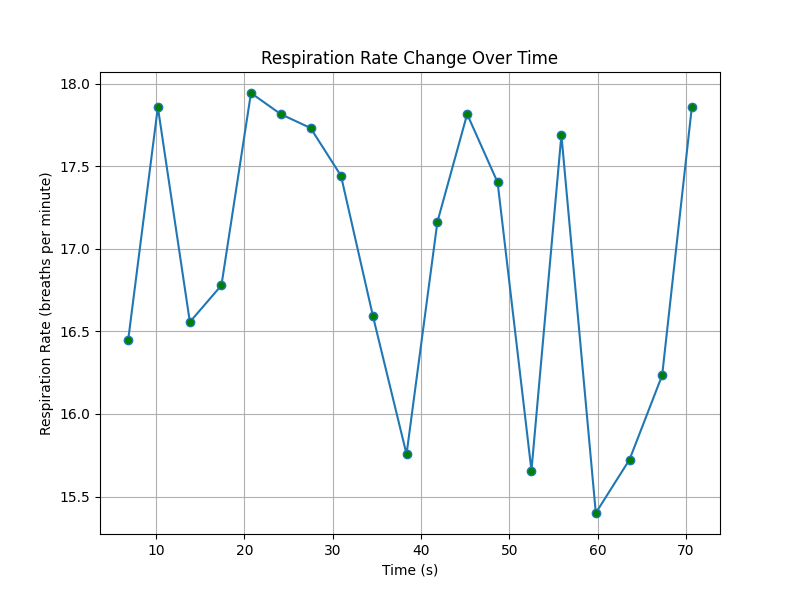

In [23]:
# For pulse rate, drop the last sample (since diff reduces length)
pr_time = pulse_locs[1:]
rr_time = resp_locs[1:]
pr_env_time = envelope_locs[1:]

plt.figure(figsize=(8, 6))
plt.plot(pr_time, pulse_rate, '-o', markerfacecolor='b', linewidth=1.5, label='PR from Filtered Signal')
plt.plot(pr_env_time, pulse_rate_env, '-x', markerfacecolor='r', linewidth=1.5, label='PR from Envelope')
plt.title('Pulse Rate Change Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(rr_time, resp_rate, '-o', markerfacecolor='g', linewidth=1.5)
plt.title('Respiration Rate Change Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Respiration Rate (breaths per minute)')
plt.grid(True)
plt.show()

<font size="3">

### Step 14: Averaging Pulse Rate and Respiration Rate Over a 1-Minute Measurement Period

To obtain clinically relevant values, we will calculate the average **Pulse Rate (PR)** and **Respiration Rate (RR)** over the first 60 seconds (1 minute) of data


</font>

In [24]:
measurement_period = 60  # seconds

if time[-1] < measurement_period:
    raise ValueError("Data duration is less than the measurement period.")

# Find indices of peaks within the first 60 seconds
measurement_indices_pr = pulse_locs <= measurement_period
measurement_indices_rr = resp_locs <= measurement_period
measurement_indices_pr_env = envelope_locs <= measurement_period

# For pulse rate (filtered signal)
pulse_locs_period = pulse_locs[measurement_indices_pr]
if len(pulse_locs_period) >= 2:
    pulse_intervals_period = np.diff(pulse_locs_period)
    pulse_rate_period = 60 / pulse_intervals_period
    avg_pulse_rate_period = np.mean(pulse_rate_period)
else:
    avg_pulse_rate_period = np.nan

# For pulse rate (envelope)
envelope_locs_period = envelope_locs[measurement_indices_pr_env]
if len(envelope_locs_period) >= 2:
    pulse_intervals_env_period = np.diff(envelope_locs_period)
    pulse_rate_env_period = 60 / pulse_intervals_env_period
    avg_pulse_rate_env_period = np.mean(pulse_rate_env_period)
else:
    avg_pulse_rate_env_period = np.nan

# For respiration rate
resp_locs_period = resp_locs[measurement_indices_rr]
if len(resp_locs_period) >= 2:
    resp_intervals_period = np.diff(resp_locs_period)
    resp_rate_period = 60 / resp_intervals_period
    avg_resp_rate_period = np.mean(resp_rate_period)
else:
    avg_resp_rate_period = np.nan

print(f"Average Pulse Rate (Filtered Signal) over first {measurement_period} s: {avg_pulse_rate_period:.2f} bpm")
print(f"Average Pulse Rate (Envelope) over first {measurement_period} s: {avg_pulse_rate_env_period:.2f} bpm")
print(f"Average Respiration Rate over first {measurement_period} s: {avg_resp_rate_period:.2f} breaths per minute")

Average Pulse Rate (Filtered Signal) over first 60 s: 64.36 bpm
Average Pulse Rate (Envelope) over first 60 s: 64.39 bpm
Average Respiration Rate over first 60 s: 17.00 breaths per minute


<font size="3">

### Step 15: Compare Averaged Values with Manual Measurements

Replace the placeholder manual values with your recorded values and compute the percentage errors.

</font>

In [25]:
# Example manual measurements (replace with your own)
manual_PR = 65    # manually recorded pulse rate (from PulseOx sensor)
manual_RR = 16    # manually counted respiration rate

extracted_PR = avg_pulse_rate_period  # from filtered pulse rate
extracted_RR = avg_resp_rate_period

error_PR = ((extracted_PR - manual_PR) / manual_PR) * 100
error_RR = ((extracted_RR - manual_RR) / manual_RR) * 100

print(f"Percentage Error in Pulse Rate: {error_PR:.2f}%")
print(f"Percentage Error in Respiration Rate: {error_RR:.2f}%")

Percentage Error in Pulse Rate: -0.98%
Percentage Error in Respiration Rate: 6.27%


<font size="3">


### Step 16: Estimating PR and RR from the PSD 

**Background:**
In addition to time-domain methods, we can estimate pulse rate (PR) and respiration rate (RR) by analyzing the frequency content of the signals. For RR, analyzing the Power Spectral Density (PSD) of the filtered respiration signal can reveal the dominant frequency corresponding to the respiration rate. For PR, we compute the PSD of the envelope of the filtered pulse rate signal to estimate PR.

**Why Use PSD for Estimating PR and RR?**

**Respiration Rate (RR)**:
- The respiration signal is dominated by low-frequency components corresponding to breathing cycles
- Analyzing the PSD of the filtered respiration signal directly highlights the dominant frequency associated with RR.
**Pulse Rate (PR)**:
- The SCG pulse signal contains multiple high-frequency components due to mechanical events within each pulsebeat
- Computing the envelope of the filtered pulse rate signal emphasizes the periodicity corresponding to pulsetbeats, making the PR frequency more prominent in the PSD

**Demonstration:**
In this step, you will explore how to estimate RR and PR from the PSD of the signals. The code is provided below. Run the code, observe the results, and understand how frequency-domain analysis can be used for physiological signal estimation.

**Understanding the Code:**
- **RR Estimation**:
    - The PSD of the filtered respiration signal is computed using the periodogram function
    - The dominant frequency within the expected RR range is identified
    - This frequency is converted to breaths per minute
- **PR Estimation**:
    - The envelope of the filtered pulse rate signal is computed using the Hilbert Transform
    - The PSD of the envelope signal is computed
    - The dominant frequency within the expected PR range is identified
    - This frequency is converted to beats per minute

</font>

C:\Users\20181588\AppData\Local\Temp\ipykernel_20808\600264786.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


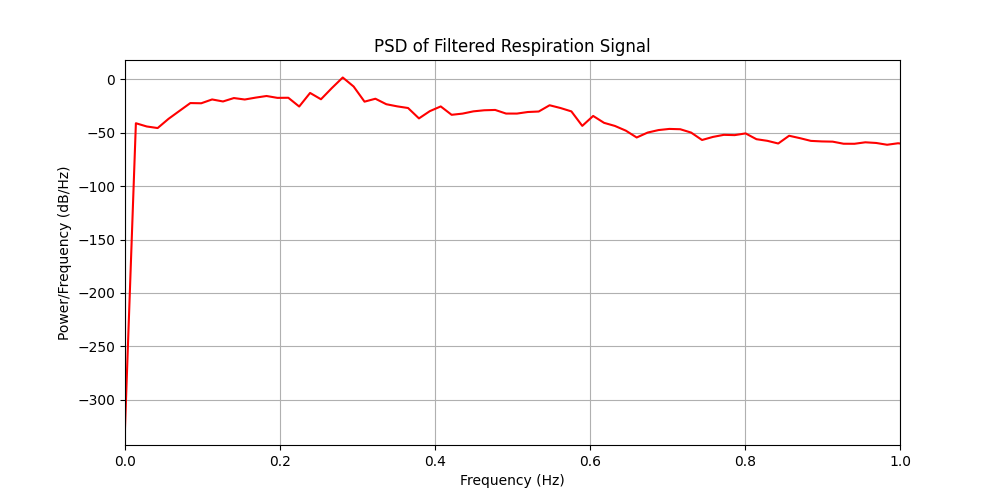

Estimated Respiration Rate from PSD: 16.86 breaths per minute


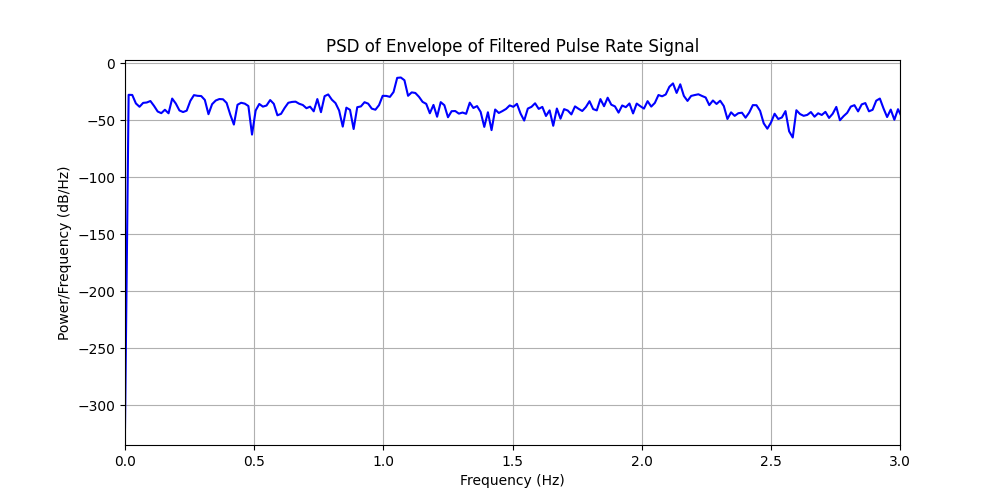

Estimated Pulse Rate from PSD of Envelope: 64.06 beats per minute


In [26]:
# --- Respiration Rate from PSD ---
F_rr_psd, Pxx_rr_psd = periodogram(filtered_rr_filtfilt, fs=fs_check)
plt.figure(figsize=(10, 5))
plt.plot(F_rr_psd, 10*np.log10(Pxx_rr_psd), 'r')
plt.xlim([0, 1])
plt.title('PSD of Filtered Respiration Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

# Identify dominant frequency for RR in 0.1-0.5 Hz
rr_freq_range = [0.1, 0.5]
rr_indices = np.where((F_rr_psd >= rr_freq_range[0]) & (F_rr_psd <= rr_freq_range[1]))[0]
if rr_indices.size > 0:
    idx_rr_peak = rr_indices[np.argmax(Pxx_rr_psd[rr_indices])]
    dominant_rr_freq = F_rr_psd[idx_rr_peak]
    estimated_rr_bpm_psd = dominant_rr_freq * 60
    print(f"Estimated Respiration Rate from PSD: {estimated_rr_bpm_psd:.2f} breaths per minute")
else:
    print("No dominant respiration frequency found.")

# --- Pulse Rate from PSD of Envelope ---
F_env_pr, Pxx_env_pr = periodogram(envelope_pr, fs=fs_check)
plt.figure(figsize=(10, 5))
plt.plot(F_env_pr, 10*np.log10(Pxx_env_pr), 'b')
plt.xlim([0, 3])
plt.title('PSD of Envelope of Filtered Pulse Rate Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

# Identify dominant frequency for PR in 0.5-3 Hz
pr_freq_range = [0.5, 3]
pr_indices = np.where((F_env_pr >= pr_freq_range[0]) & (F_env_pr <= pr_freq_range[1]))[0]
if pr_indices.size > 0:
    idx_pr_peak = pr_indices[np.argmax(Pxx_env_pr[pr_indices])]
    dominant_pr_freq = F_env_pr[idx_pr_peak]
    estimated_pr_bpm_env = dominant_pr_freq * 60
    print(f"Estimated Pulse Rate from PSD of Envelope: {estimated_pr_bpm_env:.2f} beats per minute")
else:
    print("No dominant pulse frequency found.")

<font size="3">


### Step 17: Exploring Interaction Between Pulse Rate and Respiration Rate

Respiratory Sinus Arrhythmia (RSA) is a natural variation in pulse rate that occurs during the breathing cycle. Typically, the pulse rate increases during inspiration and decreases during expiration. This interaction results from autonomic nervous system regulation and is more pronounced in some individuals.

**Why Explore PR and RR Interaction?**
- **Physiological Understanding**: Observing RSA can enhance understanding of autonomic cardiovascular control
- **Signal Processing Challenge**: Differentiating between physiological variations and artifacts is crucial in signal analysis

**Demonstration:**
In this step, you will explore the interaction between pulse rate and respiration. The provided code will help you analyze pulse rate variability in relation to the respiration cycle. Run the code, observe the results, and consider the physiological implications.

**Understanding the Code:**
- **Extract Instantaneous Pulse Rate**: Obtains pulse rate values and their corresponding times from the detected peaks
- **Resample Respiration Signal**: Aligns the respiration signal with the pulse rate time points for accurate comparison
- **Visualize Data**: Plots the instantaneous pulse rate alongside the respiration signal to visually assess potential correlations


</font>

Number of NaNs in resampled respiration signal: 0


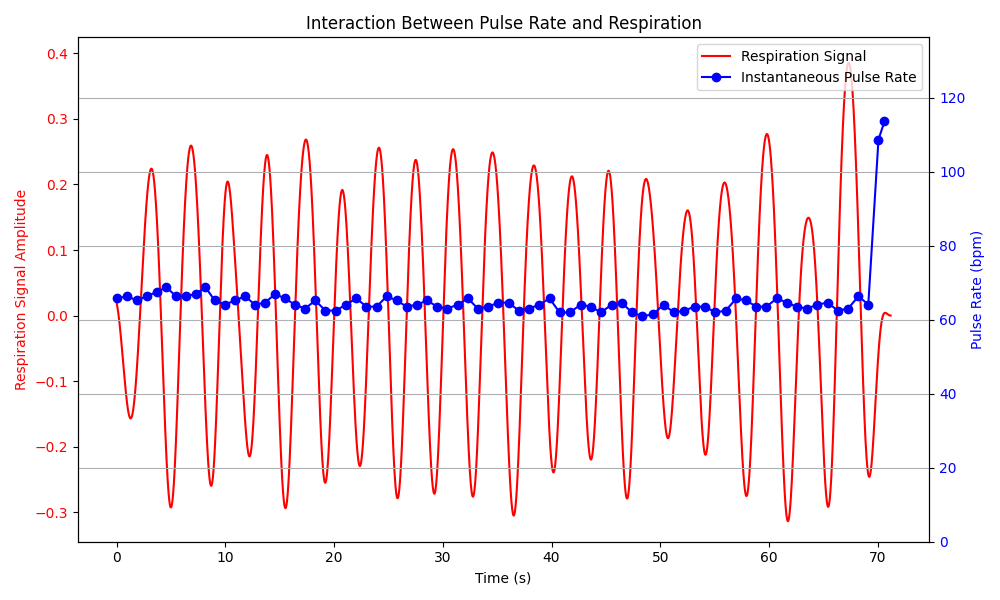

In [28]:
# Use pulse peaks (from filtered signal) and compute instantaneous PR (already computed from diff)
pr_times = pulse_locs[:-1]  # time points corresponding to pulse intervals
instantaneous_pr = pulse_rate  # from Step 11

# Resample the filtered respiration signal at pulse rate time points
resp_signal_resampled = interp1d(time, filtered_rr_filtfilt, kind='linear', fill_value="extrapolate")(pr_times)

# Check for NaN values (should be none)
num_NaNs = np.sum(np.isnan(resp_signal_resampled))
print(f"Number of NaNs in resampled respiration signal: {num_NaNs}")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot respiration on the left y-axis
color_resp = 'red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Respiration Signal Amplitude', color=color_resp)
ax1.plot(time, filtered_rr_filtfilt, color=color_resp, label='Respiration Signal')
ax1.tick_params(axis='y', labelcolor=color_resp)
ax1.set_ylim([min(filtered_rr_filtfilt)*1.1, max(filtered_rr_filtfilt)*1.1])  # optional y-limits

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot instantaneous pulse rate on the right y-axis
color_pr = 'blue'
ax2.set_ylabel('Pulse Rate (bpm)', color=color_pr)
ax2.plot(pr_times, instantaneous_pr, '-o', color=color_pr, 
         markerfacecolor=color_pr, linewidth=1.5, label='Instantaneous Pulse Rate')
ax2.tick_params(axis='y', labelcolor=color_pr)
ax2.set_ylim([0, max(instantaneous_pr)*1.2])  # optional y-limits

# Optionally combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Final adjustments
plt.title('Interaction Between Pulse Rate and Respiration')
plt.grid(True)         # If you want a grid behind both signals
fig.tight_layout()     # Avoid label overlap
plt.show()

<font size="3">


### [Optional] Step 18: Estimating PR and RR from the PSD

Apply the same analysis to accelerometry data with intentionally induced motion artifacts.

**Instructions:**
- Load the artifact-induced data.
- Repeat the preprocessing, spectral analysis, filtering, and peak detection steps.
- Compare the results to those obtained from the clean data.

**Questions:**
- How do motion artifacts affect the accuracy of HR and RR estimation?
- What strategies can be employed to mitigate the impact of motion artifacts?


</font>

<font size="3">

## Conclusion

In this notebook, we have applied signal processing techniques to real-world accelerometry data to extract pulse rate (PR) and respiration rate (RR). After resampling the data to ensure uniformly spaced time intervals, we performed spectral analysis to identify the dominant frequency components corresponding to PR and RR. Based on the spectral analysis, we designed and applied Butterworth bandpass filters to isolate the pulse and respiration components of the signal. We performed peak detection to estimate PR and RR, and calculated their averages over a clinically relevant 1-minute period.

We also explored the use of the envelope of the filtered pulse rate signal to improve PR estimation and observed how spectral analysis of the envelope can provide alternative methods for estimating PR and RR. This approach emphasizes the importance of spectral analysis and advanced signal processing techniques in understanding the frequency characteristics of physiological signals and designing appropriate methods for accurate measurement.

**Final Reflective Questions:**
- How did the spectral analysis influence your choice of filter parameters (e.g., cutoff frequencies and filter order) for PR and RR?
- What are the clinical implications of averaging PR and RR over a fixed period (e.g., 1 minute)?
- Why is it important to perform spectral analysis before filter design when working with accelerometry data?
- What advantages did using the envelope of the SCG signal provide in estimating PR?
- How do motion artifacts impact the accuracy of the detected peaks, and how might spectral analysis help in identifying and removing these artifacts?

</font>

## End of the Notebook